<img src="data/airbnb-archivbild.jpeg">

# Section Overview

In this section I want to prepare the data for modelling, use different models on the training set and certain metrics to see which model gives the best results. I will also use Hyperparameter-Tuning to get the most out of the best model. The last part of the notebook will explore how different neural networks might be usefull for this regression. 

# Setup

In [51]:
# Common Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ML Libraries
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers, regularizers

# Display options:
sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.set_option('display.max_columns', None)

# Deal with warnings:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Model Preparation 

In [5]:
df_model = pd.read_csv('data/df_model')
df_model.set_index('id', inplace = True)

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64426 entries, 3109 to 42912016
Data columns (total 51 columns):
accommodates                      64426 non-null int64
bathrooms                         64426 non-null float64
bedrooms                          64426 non-null float64
cleaning_fee                      64426 non-null float64
security_deposit                  64426 non-null float64
extra_people                      64426 non-null float64
guests_included                   64426 non-null int64
distance                          64426 non-null float64
size                              64426 non-null float64
host_response_time                64426 non-null object
host_response_rate                64426 non-null object
host_acceptance_rate              64426 non-null object
host_is_superhost                 64426 non-null bool
host_identity_verified            64426 non-null bool
neighbourhood                     64426 non-null object
property_type                     64426 non-

We will save the numeric features in a list, so we can use this list for our custom scaler later on.

In [7]:
numeric_features = list(df_model.select_dtypes(include=[np.number]).columns.values)
numeric_features.remove('price')

In [8]:
numeric_features

['accommodates',
 'bathrooms',
 'bedrooms',
 'cleaning_fee',
 'security_deposit',
 'extra_people',
 'guests_included',
 'distance',
 'size',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'number_of_reviews',
 'calculated_host_listings_count',
 'host_days_active',
 'amenities_count']

In [9]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

Since we will use a linear model later on, we will dummify the object features and drop the first dummy variable to prevent multicollinarity.

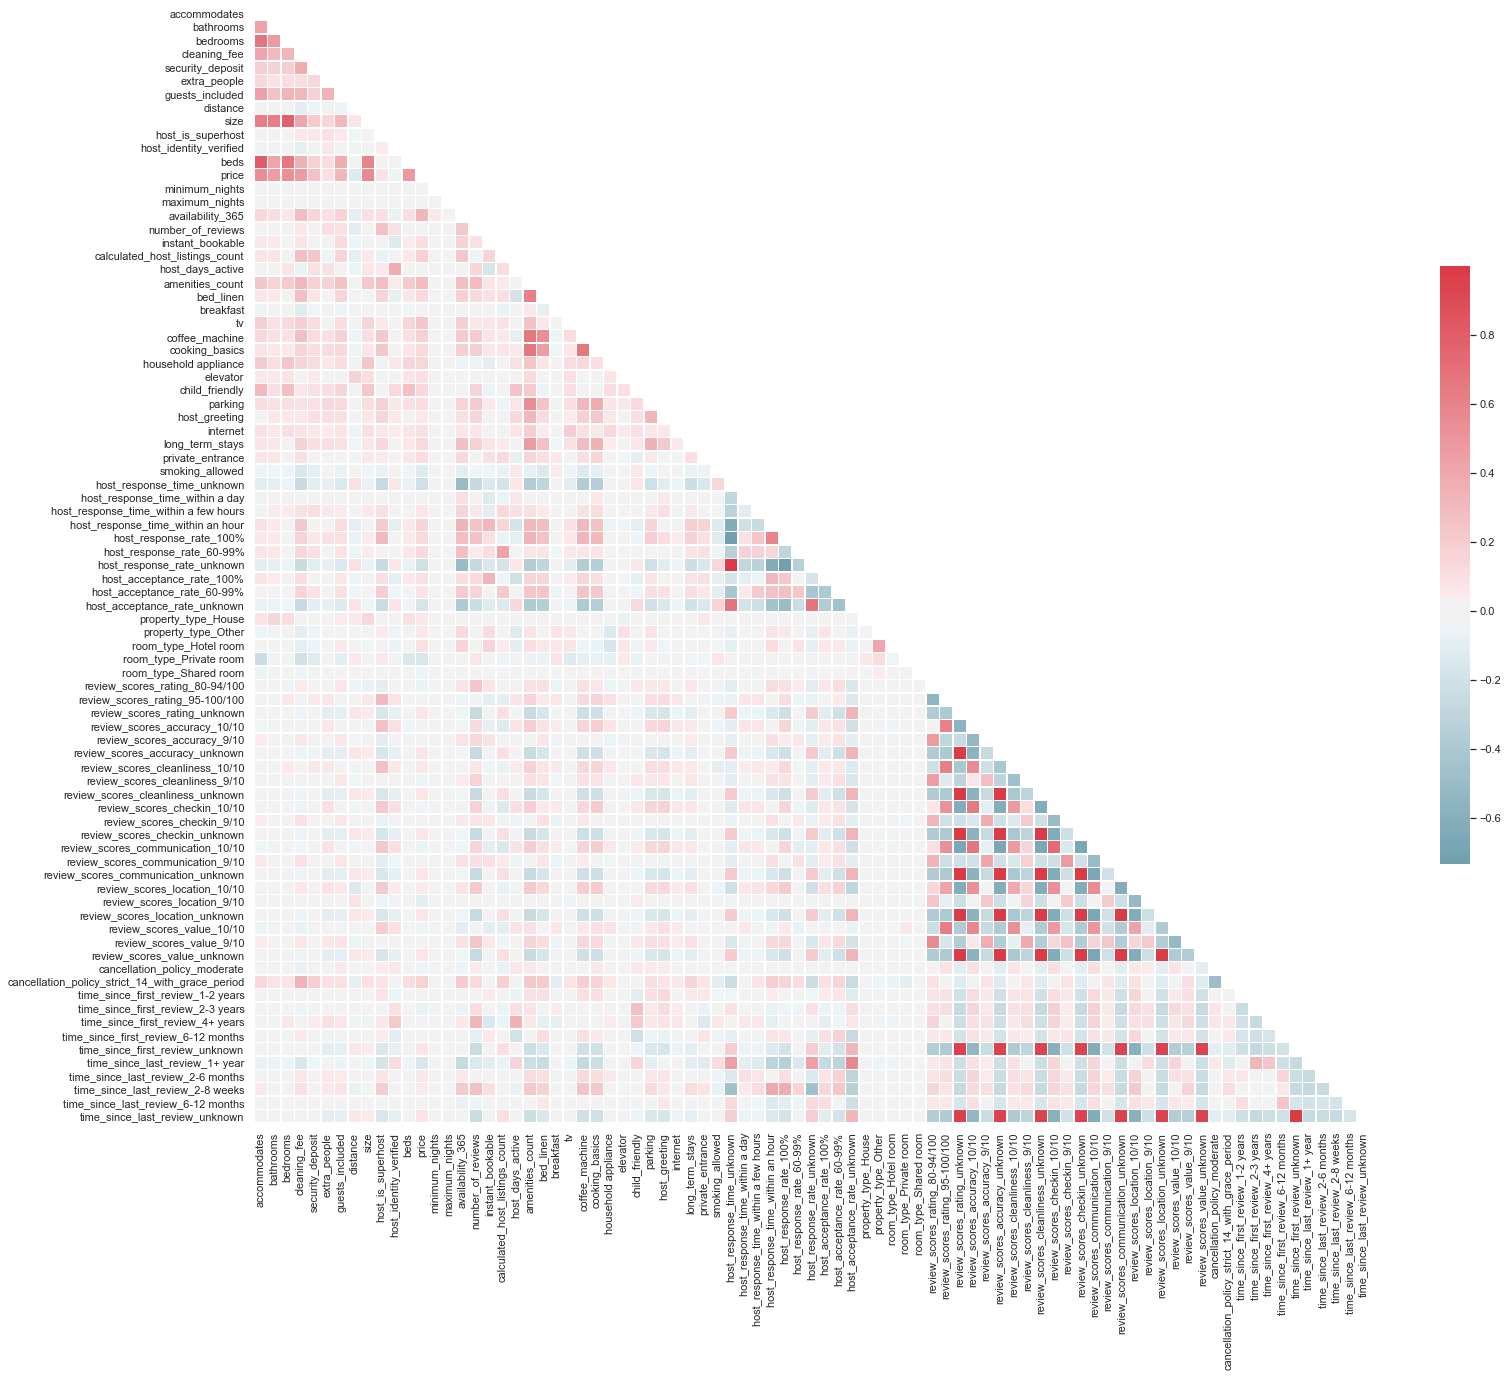

In [10]:
df_model_dum = pd.get_dummies(df_model.copy(), drop_first=True)
multi_collinearity_heatmap(df_model_dum.drop(list(df_model_dum.columns[df_model_dum.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

In [11]:
# Dropping everything that is unknown to prevent multicolinarity
df_model_dum.drop(df_model_dum.columns[df_model_dum.columns.str.endswith('unknown')], axis=1, inplace=True)

In [12]:
df_model_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64426 entries, 3109 to 42912016
Data columns (total 90 columns):
accommodates                                       64426 non-null int64
bathrooms                                          64426 non-null float64
bedrooms                                           64426 non-null float64
cleaning_fee                                       64426 non-null float64
security_deposit                                   64426 non-null float64
extra_people                                       64426 non-null float64
guests_included                                    64426 non-null int64
distance                                           64426 non-null float64
size                                               64426 non-null float64
host_is_superhost                                  64426 non-null bool
host_identity_verified                             64426 non-null bool
beds                                               64426 non-null float64
price  

In [13]:
#Pearson's r
corr_matrix = df_model_dum.corr()

In [14]:
# We will get an understanding, what will be the main factors that will drive the price.
corr_matrix ['price'].sort_values(ascending=False)

price                                              1.000000
size                                               0.561109
accommodates                                       0.545717
bedrooms                                           0.529030
beds                                               0.484746
cleaning_fee                                       0.477493
bathrooms                                          0.456894
availability_365                                   0.326284
guests_included                                    0.313509
amenities_count                                    0.294266
security_deposit                                   0.259945
tv                                                 0.240476
calculated_host_listings_count                     0.184329
coffee_machine                                     0.180720
cancellation_policy_strict_14_with_grace_period    0.169827
host_response_time_within an hour                  0.165591
household appliance                     

In [15]:
# y will be our target variable
y = df_model_dum.pop("price")

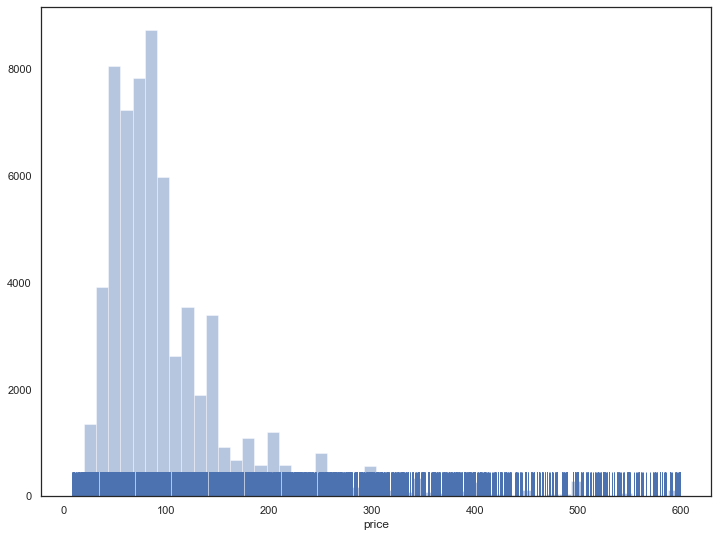

In [16]:
f, ax = plt.subplots(figsize=(12, 9))
sns.distplot(y, kde=False, rug=True);

In [17]:
# A possible way to deal with the skewness is to logarithmic the price, but for better interpretabilty of the results I decided not to do it.
#y = np.log(y)

In [18]:
X = df_model_dum

Train Test Split

In [19]:
X_modeltrain, X_finalval, y_modeltrain, y_finalval = train_test_split(X,y,random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X_modeltrain,y_modeltrain,random_state=10)

We use a somewhat custom scaler, to only scale the numeric columns. 

In [20]:
standard_transformer = Pipeline(steps=[
        ('standard', StandardScaler())])

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', standard_transformer , numeric_features)
        ])

In [21]:
scaler = preprocessor.fit(X_train)

In [22]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=list(X_train.columns))
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))

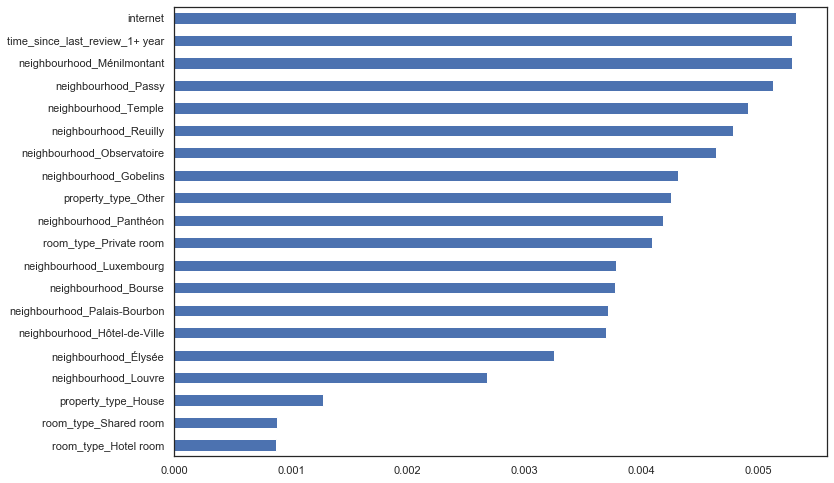

In [23]:
# It would be interesting to see, if the models would perform better 
# by dropping the least significant features and reduce dimensionality
lab_enc = preprocessing.LabelEncoder()

feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train_scaled,lab_enc.fit_transform(y_train))

plt.figure()
feat_importances = pd.Series(feature_model.feature_importances_, index=X_train_scaled.columns)
feat_importances.nsmallest(20).plot(kind='barh')
plt.show()

Since some of the features do not seem to have a huge influence when we look at tree based feature importance, we will drop the least important elements to reduce the complexity of the model.

In [24]:
features_to_drop = feat_importances.nsmallest(20)

In [25]:
X_train_scaled.drop(features_to_drop.index,axis=1,inplace=True)

In [26]:
X_test_scaled.drop(features_to_drop.index,axis=1,inplace=True)

In [27]:
X_train_scaled = X_train_scaled.applymap(float)
X_test_scaled = X_test_scaled.applymap(float)

# Predictive modeling

## Baseline Model: Linear Regression

In [28]:
def linear_reg(input_x, input_y, cv=5):
    
    model_LR= LinearRegression()

    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_LR = GridSearchCV(estimator=model_LR,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_LR.fit(input_x, input_y)
    best_parameters_LR = grid_search_LR.best_params_  
    best_score_LR = grid_search_LR.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)

In [29]:
linear_reg(X_train_scaled, y_train, cv=4)

{'copy_X': True, 'fit_intercept': True, 'normalize': False}
-3035.3653556344675


In [30]:
lr = LinearRegression(copy_X= True, fit_intercept = True, normalize = False)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, lr_pred)))   
print('R2 %f' % r2_score(y_test, lr_pred))

RMSE: 55.878274
R2 0.533879


### Polinomial Regression

In [31]:
Poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_scaled_poly = Poly.fit_transform(X_train_scaled)
X_test_scaled_poly = Poly.fit_transform(X_test_scaled)

In [32]:
lr = LinearRegression(copy_X= True, fit_intercept = True, normalize = False)
lr.fit(X_train_scaled_poly, y_train)
lr_pred = lr.predict(X_test_scaled_poly)
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, lr_pred)))   
print('R2 %f' % r2_score(y_test, lr_pred))

RMSE: 50.591469
R2 0.617909


## Ridge Regression

In [33]:
def ridge_reg(input_x, input_y, cv=5):
    
    model_Ridge= Ridge()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_Ridge = GridSearchCV(estimator=model_Ridge,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_Ridge.fit(input_x, input_y)
    best_parameters_Ridge = grid_search_Ridge.best_params_  
    best_score_Ridge = grid_search_Ridge.best_score_ 
    print(best_parameters_Ridge)
    print(best_score_Ridge)

In [34]:
ridge_reg(X_train_scaled, y_train, cv=4)

{'alpha': 0.01, 'normalize': True}
-3034.4030478533737


In [35]:
ridge = Ridge(alpha = 0.01, normalize = True)
ridge.fit(X_train_scaled, y_train)           
pred_ridge = ridge.predict(X_test_scaled)
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred_ridge)))   
print('R2 %f' % r2_score(y_test, pred_ridge))

RMSE: 55.883353
R2 0.533794


### Polinomial Ridge Regression

In [36]:
ridge = Ridge(alpha = 0.01, normalize = True)
ridge.fit(X_train_scaled_poly, y_train)           
pred_ridge = ridge.predict(X_test_scaled_poly)
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred_ridge)))   
print('R2 %f' % r2_score(y_test, pred_ridge))

RMSE: 50.219366
R2 0.623509


## Lasso Regression

In [37]:
def lasso_reg(input_x, input_y, cv=5):
    
    model_Lasso= Lasso()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_lasso = GridSearchCV(estimator=model_Lasso,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_lasso.fit(input_x, input_y)
    best_parameters_lasso = grid_search_lasso.best_params_  
    best_score_lasso = grid_search_lasso.best_score_ 
    print(best_parameters_lasso)
    print(best_score_lasso)

In [38]:
lasso_reg(X_train_scaled, y_train, cv=4)

{'alpha': 0.001, 'normalize': True}
-3034.0174571888033


In [39]:
Lasso = Lasso(alpha = 0.001, normalize =True)
Lasso.fit(X_train_scaled, y_train)
pred_Lasso = Lasso.predict(X_test_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, pred_Lasso)))
print('R2 %f' % r2_score(y_test, pred_Lasso))

RMSE: 55.940511
R2 0.532840


### Polinomial Lasso Regression

In [42]:
Lasso = Lasso(alpha = 0.001, normalize =True)
Lasso.fit(X_train_scaled_poly, y_train)
pred_Lasso = Lasso.predict(X_test_scaled_poly)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, pred_Lasso)))
print('R2 %f' % r2_score(y_test, pred_Lasso))

RMSE: 49.989066
R2 0.626954


## ElasticNet Regression

In [43]:
def elastic_reg(input_x, input_y,cv=5):
    
    model_grid_Elastic= ElasticNet()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_elastic = GridSearchCV(estimator=model_grid_Elastic,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_elastic.fit(input_x, input_y)
    best_parameters_elastic = grid_search_elastic.best_params_  
    best_score_elastic = grid_search_elastic.best_score_ 
    print(best_parameters_elastic)
    print(best_score_elastic)

In [44]:
elastic_reg(X_train_scaled, y_train, cv=4)

{'alpha': 0.01, 'normalize': False}
-3033.9686167575055


In [45]:
model_enet = ElasticNet(alpha = 0.01, normalize = False)
model_enet.fit(X_train_scaled, y_train) 
pred_test_enet= model_enet.predict(X_test_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_enet))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_enet))

RMSE: 55.899491
R2 0.533525


### Polinomial Elastic Net Regression

In [46]:
model_enet = ElasticNet(alpha = 0.01, normalize = False)
model_enet.fit(X_train_scaled_poly, y_train) 
pred_test_enet= model_enet.predict(X_test_scaled_poly)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_enet))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_enet))

RMSE: 49.811441
R2 0.629600


## Adaboost

In [47]:
ada_reg = AdaBoostRegressor()
ada_reg.fit(X_train_scaled, y_train)
pred_train_ada = ada_reg.predict(X_train_scaled)
pred_test_ada = ada_reg.predict(X_test_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_ada))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_ada))

RMSE: 68.582892
R2 0.297827


## XGBoost

In [49]:
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror')
xgb_reg.fit(X_train_scaled, y_train)
pred_train_xgb = xgb_reg.predict(X_train_scaled)
pred_test_xgb = xgb_reg.predict(X_test_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_xgb))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_xgb))

RMSE: 50.187808
R2 0.623982


## Algorithm Comparison

LR: -55.084720 (1.282847)
RI: -55.074737 (1.276869)
LA: -55.065517 (1.269499)
EL: -55.068173 (1.265839)
AB: -73.154512 (9.002527)
XG: -49.179137 (0.945402)


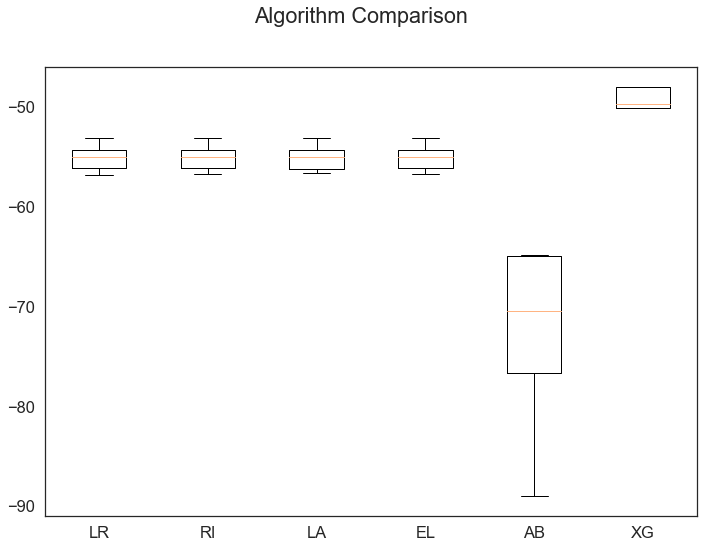

In [53]:
modellist = []
modellist.append(('LR', LinearRegression(copy_X= True, fit_intercept = True, normalize = False)))
modellist.append(('RI', Ridge(alpha = 0.01, normalize = True)))
modellist.append(('LA', Lasso(alpha = 0.001, normalize =True)))
modellist.append(('EL', ElasticNet(alpha = 0.01, normalize = False)))
modellist.append(('AB', AdaBoostRegressor()))
modellist.append(('XG', xgb.XGBRegressor(objective = 'reg:squarederror')))


# evaluate each model in turn
results = []
names = []
scoring = 'neg_root_mean_squared_error'
for name, model in modellist:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We will go on with the XGBoost Model, which promisses to give the best results with tuning in our case.

## Model Tuning

In [199]:
#create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
xgb_reg_grid_search = GridSearchCV(xgb_reg, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
xgb_reg_grid_search.fit(X_train_scaled, y_train)

#print best estimator parameters found during the grid search
print(xgb_reg_grid_search.best_params_)

[21:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


## Tuned XGBoost

In [54]:
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, 
                           max_depth=7, n_estimators=200, random_state=4,objective = 'reg:squarederror')
xgb_reg.fit(X_train_scaled, y_train)
pred_train_xgb = xgb_reg.predict(X_train_scaled)
pred_test_xgb = xgb_reg.predict(X_test_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test,pred_test_xgb))) #RMSE
print('R2 %f' % r2_score(y_test, pred_test_xgb))

RMSE: 44.340049
R2 0.706502


After tuning the XGBoost Model we get a significant improvement of our RMSE and R2.

In [55]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_scaled.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
time_since_last_review_6-12 months,0.003243
review_scores_value_10/10,0.004096
review_scores_checkin_9/10,0.004968
time_since_first_review_6-12 months,0.004988
review_scores_communication_10/10,0.005072
review_scores_accuracy_10/10,0.005079
review_scores_communication_9/10,0.005094
review_scores_accuracy_9/10,0.005118
host_response_time_within a day,0.005441
time_since_last_review_2-8 weeks,0.005642


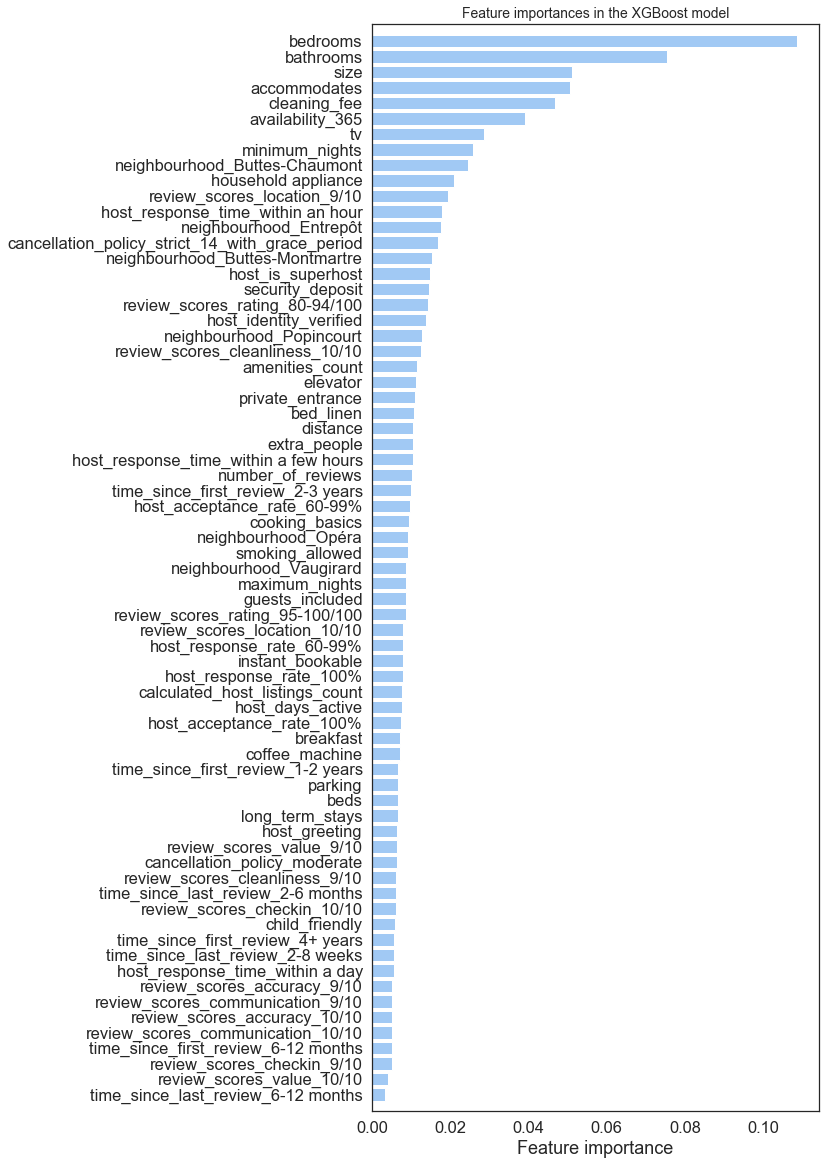

In [56]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Not very surprisingly features like amount of bedrooms, bathrooms, size of the appartment and how many are allowed to stay in the apartment seem to quite a bit of influence in the model. It did not expect for tv to have such a big impact. The availability and certain neighboorhoods also have a quite significant influence.

# Final Test

In [57]:
X_finalval_scaled = pd.DataFrame(scaler.transform(X_finalval), columns=list(X_finalval.columns))
X_finalval_scaled.drop(features_to_drop.index,axis=1,inplace=True)
X_finalval_scaled = X_finalval_scaled.applymap(float)   

In [58]:
pred_test_xgb = xgb_reg.predict(X_finalval_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_finalval,pred_test_xgb))) #RMSE
print('R2 %f' % r2_score(y_finalval, pred_test_xgb))

RMSE: 42.340984
R2 0.717398


Our final test set gives us a slighty better result as the test set. Our RMSE is at ca. 42 Euros, which is quite a big range.

# Example Case

With this Example Case we want to give recommendations to a host, what simple things he can change in his appartment to get a better price per night.

In [377]:
X_example = X_finalval.head(1)
# Our Example should have one bedroom
X_example.iloc[:,2] = 1
# Our Example has no TV
X_example.iloc[:,25] = False

In [378]:
# List of possible Variables we could tweak
List_variables = ['accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee',
            'security_deposit', 'extra_people', 'guests_included', 'distance',
            'size', 'host_is_superhost', 'host_identity_verified', 'beds',
            'minimum_nights', 'maximum_nights', 'availability_365',
            'number_of_reviews', 'instant_bookable',
            'calculated_host_listings_count', 'host_days_active', 'amenities_count',
            'bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics',
            'household appliance', 'elevator', 'child_friendly', 'parking',
            'host_greeting', 'internet', 'long_term_stays', 'private_entrance',
            'smoking_allowed', 'host_response_time_within a day',
            'host_response_time_within a few hours',
            'host_response_time_within an hour', 'host_response_rate_100%',
            'host_response_rate_60-99%', 'host_acceptance_rate_100%',
            'host_acceptance_rate_60-99%','review_scores_rating_80-94/100', 'review_scores_rating_95-100/100',
            'review_scores_accuracy_10/10', 'review_scores_accuracy_9/10',
            'review_scores_cleanliness_10/10', 'review_scores_cleanliness_9/10',
            'review_scores_checkin_10/10', 'review_scores_checkin_9/10',
            'review_scores_communication_10/10', 'review_scores_communication_9/10',
            'review_scores_location_10/10', 'review_scores_location_9/10',
            'review_scores_value_10/10', 'review_scores_value_9/10',
            'cancellation_policy_moderate','cancellation_policy_strict_14_with_grace_period']    

We look at an appartment in the neighbourhood Hôtel de Ville.
We want to find out three easy recommendations for the host to drive up the price, accoding to our model.
We have to keep in mind that we an RMSE of 42 Euro. 

In [382]:
X_example

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,host_is_superhost,host_identity_verified,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,host_days_active,amenities_count,bed_linen,breakfast,tv,coffee_machine,cooking_basics,household appliance,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,private_entrance,smoking_allowed,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_100%,host_response_rate_60-99%,host_acceptance_rate_100%,host_acceptance_rate_60-99%,neighbourhood_Bourse,neighbourhood_Buttes-Chaumont,neighbourhood_Buttes-Montmartre,neighbourhood_Entrepôt,neighbourhood_Gobelins,neighbourhood_Hôtel-de-Ville,neighbourhood_Louvre,neighbourhood_Luxembourg,neighbourhood_Ménilmontant,neighbourhood_Observatoire,neighbourhood_Opéra,neighbourhood_Palais-Bourbon,neighbourhood_Panthéon,neighbourhood_Passy,neighbourhood_Popincourt,neighbourhood_Reuilly,neighbourhood_Temple,neighbourhood_Vaugirard,neighbourhood_Élysée,property_type_House,property_type_Other,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_communication_10/10,review_scores_communication_9/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_value_10/10,review_scores_value_9/10,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23113313,2,1.0,1.0,70.0,200.0,0.0,1,1.458955,30.535467,False,False,1.0,90,360,170,1,True,11,1025.0,23,False,False,False,True,True,False,False,False,False,True,True,True,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0


In [380]:
def modelprediction(X_example, accomodates=2, guests_included=1, beds=1, number_of_reviews = 1, bed_linen=False, household_appliance=False):
    X_example.iloc[:,0] = accomodates
    X_example.iloc[:,6] = guests_included
    X_example.iloc[:,11] = beds
    X_example.iloc[:,15] = number_of_reviews
    X_example.iloc[:,20] = bed_linen
    X_example.iloc[:,25] = household_appliance
    X_example_scaled = pd.DataFrame(scaler.transform(X_example), columns=list(X_example.columns))
    X_example_scaled.drop(features_to_drop.index,axis=1,inplace=True)
    X_example_scaled = X_example_scaled.applymap(float)
    pred_example_xgb = xgb_reg.predict(X_example_scaled)
    print(pred_example_xgb)

In [381]:
modelprediction(X_example)

[105.86816]


In [383]:
modelprediction(X_example, household_appliance=True)

[113.59463]


In [384]:
modelprediction(X_example, household_appliance=True, accomodates=3)

[124.85596]


In [385]:
modelprediction(X_example, household_appliance=True, accomodates=3, bed_linen=True)

[125.75764]


By integrating household appliances, creating space for a third person in the appartment and adding bed linen the host is able to raise the price from 105 Euros to 125 Euros with an RMSE of 42 Euro.

# Neural Network

In [322]:
# Building the model
nn1 = models.Sequential()
nn1.add(layers.Dense(512, input_shape=(X_train_scaled.shape[1],), activation='relu'))
nn1.add(layers.Dense(256, activation='relu'))
nn1.add(layers.Dense(128, activation='relu'))
nn1.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn1.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               35840     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 200,193
Trainable params: 200,193
Non-trainable params: 0
_________________________________________________________________
None


In [326]:
from keras.callbacks.callbacks import ModelCheckpoint
#set parameters
batch_size = 32
epochs = 40

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = nn1.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_scaled, y_test),callbacks=callbacks_list)

Train on 36239 samples, validate on 12080 samples
Epoch 1/40
36239/36239 [==============================] - 16s 431us/step - loss: 3241.4001 - mean_squared_error: 3241.3994 - val_loss: 2849.6660 - val_mean_squared_error: 2849.6653

Epoch 00001: val_loss improved from inf to 2849.66597, saving model to weights-improvement-01-2849.67.hdf5
Epoch 2/40
36239/36239 [==============================] - 15s 420us/step - loss: 2571.9509 - mean_squared_error: 2571.9497 - val_loss: 2668.0005 - val_mean_squared_error: 2667.9998

Epoch 00002: val_loss improved from 2849.66597 to 2668.00051, saving model to weights-improvement-02-2668.00.hdf5
Epoch 3/40
36239/36239 [==============================] - 16s 448us/step - loss: 2427.9530 - mean_squared_error: 2427.9539 - val_loss: 2566.9001 - val_mean_squared_error: 2566.9004

Epoch 00003: val_loss improved from 2668.00051 to 2566.90015, saving model to weights-improvement-03-2566.90.hdf5
Epoch 4/40
36239/36239 [==============================] - 17s 482us/s

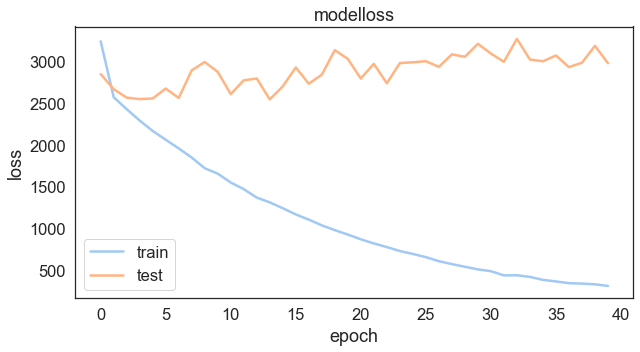

In [327]:
#plot training history
figsize=(10,5)
ax,_ = plt.subplots(figsize=figsize)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('modelloss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upperleft')
plt.show()

In [330]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(512,input_shape=(X_train_scaled.shape[1],), activation= 'relu'))
nn2.add(layers.Dropout(0.2))
nn2.add(layers.Dense(256, activation= 'relu'))
nn2.add(layers.Dropout(0.2))
nn2.add(layers.Dense(128, activation= 'relu'))
nn2.add(layers.Dense(1, activation= 'linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               35840     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 200,193
Trainable params: 200,193
Non-trainable params: 0
________________________________________________

In [331]:
from keras.callbacks.callbacks import ModelCheckpoint
#set parameters
batch_size = 32
epochs = 40

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = nn2.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_scaled, y_test),callbacks=callbacks_list)

Train on 36239 samples, validate on 12080 samples
Epoch 1/40
36239/36239 [==============================] - 19s 531us/step - loss: 3267.0082 - mean_squared_error: 3267.0083 - val_loss: 2981.4424 - val_mean_squared_error: 2981.4421

Epoch 00001: val_loss improved from inf to 2981.44237, saving model to weights-improvement-01-2981.44.hdf5
Epoch 2/40
36239/36239 [==============================] - 21s 571us/step - loss: 2738.5094 - mean_squared_error: 2738.5112 - val_loss: 2660.5695 - val_mean_squared_error: 2660.5693

Epoch 00002: val_loss improved from 2981.44237 to 2660.56952, saving model to weights-improvement-02-2660.57.hdf5
Epoch 3/40
36239/36239 [==============================] - 23s 635us/step - loss: 2551.2227 - mean_squared_error: 2551.2236 - val_loss: 2545.7099 - val_mean_squared_error: 2545.7112

Epoch 00003: val_loss improved from 2660.56952 to 2545.70991, saving model to weights-improvement-03-2545.71.hdf5
Epoch 4/40
36239/36239 [==============================] - 23s 624us/s

36239/36239 [==============================] - 23s 643us/step - loss: 1184.8726 - mean_squared_error: 1184.8727 - val_loss: 2505.6559 - val_mean_squared_error: 2505.6550

Epoch 00034: val_loss did not improve from 2361.54334
Epoch 35/40
36239/36239 [==============================] - 24s 651us/step - loss: 1178.7722 - mean_squared_error: 1178.7727 - val_loss: 2607.6903 - val_mean_squared_error: 2607.6909

Epoch 00035: val_loss did not improve from 2361.54334
Epoch 36/40
36239/36239 [==============================] - 23s 641us/step - loss: 1138.6620 - mean_squared_error: 1138.6625 - val_loss: 2497.3439 - val_mean_squared_error: 2497.3435

Epoch 00036: val_loss did not improve from 2361.54334
Epoch 37/40
36239/36239 [==============================] - 19s 532us/step - loss: 1135.9263 - mean_squared_error: 1135.9260 - val_loss: 2683.5511 - val_mean_squared_error: 2683.5510

Epoch 00037: val_loss did not improve from 2361.54334
Epoch 38/40
36239/36239 [==============================] - 19s 5

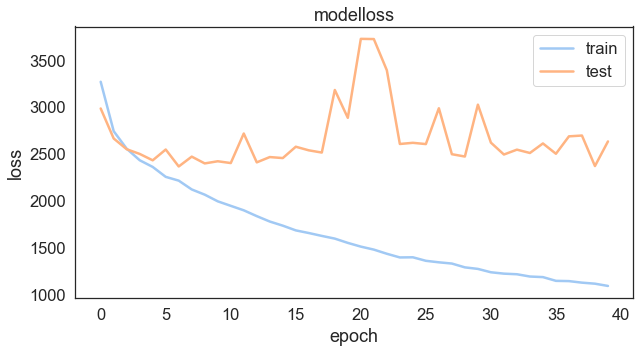

In [332]:
#plot training history
figsize=(10,5)
ax,_ = plt.subplots(figsize=figsize)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('modelloss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upperleft')
plt.show()

In [335]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(512,input_shape=(X_train_scaled.shape[1],), activation= 'relu'))
nn3.add(layers.Dropout(0.5))
nn3.add(layers.Dense(512, activation= 'relu'))
nn3.add(layers.Dropout(0.5))
nn3.add(layers.Dense(256, activation= 'relu'))
nn3.add(layers.Dropout(0.5))
nn3.add(layers.Dense(128, activation= 'relu'))
nn3.add(layers.Dense(1, activation= 'linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='rmsprop',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 512)               35840     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)              

In [373]:
batch_size = 100
epochs = 40

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = nn3.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_scaled, y_test),callbacks=callbacks_list)

Train on 36239 samples, validate on 12080 samples
Epoch 1/40
36239/36239 [==============================] - 13s 369us/step - loss: 2307.2394 - mean_squared_error: 2307.2385 - val_loss: 2478.3198 - val_mean_squared_error: 2478.3196

Epoch 00001: val_loss improved from inf to 2478.31984, saving model to weights-improvement-01-2478.32.hdf5
Epoch 2/40
36239/36239 [==============================] - 14s 389us/step - loss: 2286.7663 - mean_squared_error: 2286.7673 - val_loss: 2315.5074 - val_mean_squared_error: 2315.5068

Epoch 00002: val_loss improved from 2478.31984 to 2315.50742, saving model to weights-improvement-02-2315.51.hdf5
Epoch 3/40
36239/36239 [==============================] - 17s 468us/step - loss: 2221.6939 - mean_squared_error: 2221.6936 - val_loss: 2395.9680 - val_mean_squared_error: 2395.9680

Epoch 00003: val_loss did not improve from 2315.50742
Epoch 4/40
36239/36239 [==============================] - 16s 454us/step - loss: 2155.1517 - mean_squared_error: 2155.1519 - val_

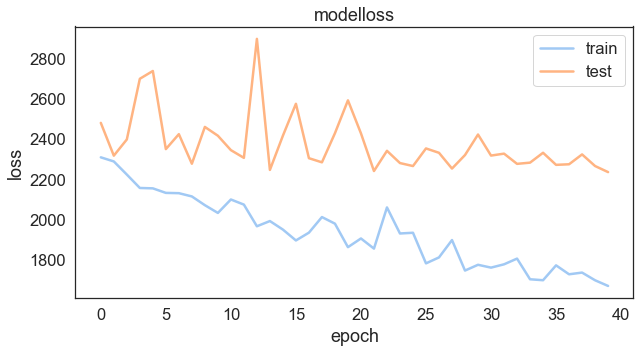

In [374]:
#plot training history
figsize=(10,5)
ax,_ = plt.subplots(figsize=figsize)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('modelloss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upperleft')
plt.show()

In [338]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(512,input_shape=(X_train_scaled.shape[1],),kernel_regularizer=regularizers.l2(0.0001), activation= 'relu'))
nn4.add(layers.Dropout(0.2))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation= 'relu'))
nn4.add(layers.Dropout(0.2))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation= 'relu'))
nn4.add(layers.Dropout(0.2))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation= 'relu'))
nn4.add(layers.Dense(1, activation= 'linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='rmsprop',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               35840     
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)              

In [340]:
batch_size = 32
epochs = 40

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = nn4.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_scaled, y_test),callbacks=callbacks_list)

Train on 36239 samples, validate on 12080 samples
Epoch 1/40
36239/36239 [==============================] - 55s 2ms/step - loss: 3268.0274 - mean_squared_error: 3267.9026 - val_loss: 2706.5209 - val_mean_squared_error: 2706.4170

Epoch 00001: val_loss improved from inf to 2706.52087, saving model to weights-improvement-01-2706.52.hdf5
Epoch 2/40
36239/36239 [==============================] - 63s 2ms/step - loss: 2796.1269 - mean_squared_error: 2796.0276 - val_loss: 2532.0812 - val_mean_squared_error: 2531.9863

Epoch 00002: val_loss improved from 2706.52087 to 2532.08119, saving model to weights-improvement-02-2532.08.hdf5
Epoch 3/40
36239/36239 [==============================] - 69s 2ms/step - loss: 2665.2396 - mean_squared_error: 2665.1431 - val_loss: 2383.5399 - val_mean_squared_error: 2383.4421

Epoch 00003: val_loss improved from 2532.08119 to 2383.53989, saving model to weights-improvement-03-2383.54.hdf5
Epoch 4/40
36239/36239 [==============================] - 66s 2ms/step - lo

36239/36239 [==============================] - 54s 1ms/step - loss: 1460.5467 - mean_squared_error: 1460.1622 - val_loss: 2260.7563 - val_mean_squared_error: 2260.3638

Epoch 00033: val_loss did not improve from 2168.23084
Epoch 34/40
36239/36239 [==============================] - 53s 1ms/step - loss: 1452.1441 - mean_squared_error: 1451.7438 - val_loss: 2317.1070 - val_mean_squared_error: 2316.7000

Epoch 00034: val_loss did not improve from 2168.23084
Epoch 35/40
36239/36239 [==============================] - 56s 2ms/step - loss: 1503.9318 - mean_squared_error: 1503.5176 - val_loss: 2317.4697 - val_mean_squared_error: 2317.0461

Epoch 00035: val_loss did not improve from 2168.23084
Epoch 36/40
36239/36239 [==============================] - 53s 1ms/step - loss: 1415.2193 - mean_squared_error: 1414.7904 - val_loss: 2386.1359 - val_mean_squared_error: 2385.6987

Epoch 00036: val_loss did not improve from 2168.23084
Epoch 37/40
36239/36239 [==============================] - 53s 1ms/step 

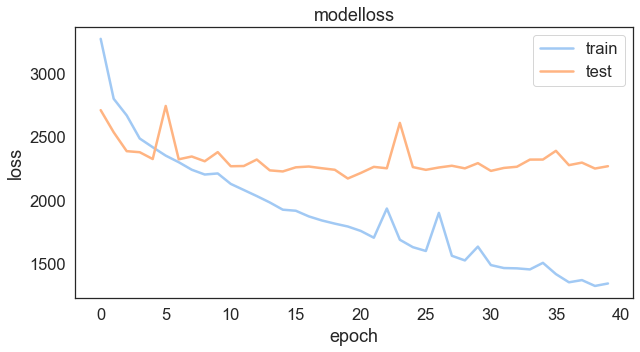

In [341]:
#plot training history
figsize=(10,5)
ax,_ = plt.subplots(figsize=figsize)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('modelloss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upperleft')
plt.show()

In [351]:
# Building the model
nn5 = models.Sequential()
nn5.add(layers.Dense(512,input_shape=(X_train_scaled.shape[1],),kernel_regularizer=regularizers.l2(0.0001), activation= 'relu'))
nn5.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation= 'relu'))
nn5.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation= 'relu'))
nn5.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation= 'relu'))
nn5.add(layers.Dense(1, activation= 'linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 512)               35840     
_________________________________________________________________
dense_57 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_58 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_59 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 513       
Total params: 824,321
Trainable params: 824,321
Non-trainable params: 0
_________________________________________________________________
None


In [352]:
batch_size = 50
epochs = 40

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = nn5.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_scaled, y_test),callbacks=callbacks_list)

Train on 36239 samples, validate on 12080 samples
Epoch 1/40
36239/36239 [==============================] - 41s 1ms/step - loss: 3315.0288 - mean_squared_error: 3213.7312 - val_loss: 2764.2012 - val_mean_squared_error: 2676.2378

Epoch 00001: val_loss improved from inf to 2764.20115, saving model to weights-improvement-01-2764.20.hdf5
Epoch 2/40
36239/36239 [==============================] - 43s 1ms/step - loss: 2551.9302 - mean_squared_error: 2468.3477 - val_loss: 2763.5053 - val_mean_squared_error: 2683.7512

Epoch 00002: val_loss improved from 2764.20115 to 2763.50534, saving model to weights-improvement-02-2763.51.hdf5
Epoch 3/40
36239/36239 [==============================] - 44s 1ms/step - loss: 2379.4573 - mean_squared_error: 2302.6094 - val_loss: 2474.8936 - val_mean_squared_error: 2401.0432

Epoch 00003: val_loss improved from 2763.50534 to 2474.89358, saving model to weights-improvement-03-2474.89.hdf5
Epoch 4/40
36239/36239 [==============================] - 45s 1ms/step - lo


Epoch 00034: val_loss did not improve from 2284.72364
Epoch 35/40
36239/36239 [==============================] - 53s 1ms/step - loss: 481.6022 - mean_squared_error: 429.7704 - val_loss: 2631.1489 - val_mean_squared_error: 2579.5476

Epoch 00035: val_loss did not improve from 2284.72364
Epoch 36/40
36239/36239 [==============================] - 54s 1ms/step - loss: 480.2225 - mean_squared_error: 428.6266 - val_loss: 2633.7928 - val_mean_squared_error: 2582.0188

Epoch 00036: val_loss did not improve from 2284.72364
Epoch 37/40
36239/36239 [==============================] - 50s 1ms/step - loss: 456.7107 - mean_squared_error: 404.8799 - val_loss: 2643.4211 - val_mean_squared_error: 2591.4741

Epoch 00037: val_loss did not improve from 2284.72364
Epoch 38/40
36239/36239 [==============================] - 48s 1ms/step - loss: 435.8146 - mean_squared_error: 383.7172 - val_loss: 2623.6413 - val_mean_squared_error: 2571.5435

Epoch 00038: val_loss did not improve from 2284.72364
Epoch 39/40
3

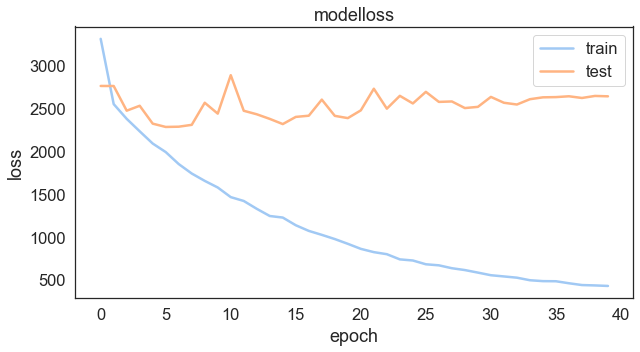

In [353]:
#plot training history
figsize=(10,5)
ax,_ = plt.subplots(figsize=figsize)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('modelloss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upperleft')
plt.show()

In [361]:
import os
import copy

saved_loss_file = None
loss_min = 100000
# r=root, d=directories, f = files
for r, d, f in os.walk('./'):
    for file in f:
        if '.hdf5' in file:
            filename = os.path.join(r, file)
            loss = int(filename.split('-')[3].split('.')[0])
            if loss < loss_min:
                loss_min = loss
                saved_loss_file = filename
                
print("Saved min loss : ",loss_min,"\nFile :",saved_loss_file)

Saved min loss :  2168 
File : ./weights-improvement-20-2168.23.hdf5


In [362]:
#load model
from keras.models import load_model
best_model = load_model(saved_loss_file)

For our prediction we take the best result of our tested neural networks, which was from nn4.

In [366]:
#prediction
pred_nn = best_model.predict(X_test_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, pred_nn))) #RMSE
print('R2 %f' % r2_score(y_test, pred_nn))

RMSE: 46.561663
R2 0.676354


In [367]:
pred_nn = best_model.predict(X_finalval_scaled)
print('RMSE: %f' % np.sqrt(mean_squared_error(y_finalval,pred_nn))) #RMSE
print('R2 %f' % r2_score(y_finalval, pred_nn))

RMSE: 55.239867
R2 0.518985


Unfortunately, we were not able to find a neural network, that could beat the predictive power of the tuned XGBoost Model.

# Conclusion

* Our EDA offers sereval insides that can be usefull for host as well as guest:
    * What are on average the cheapest neighbourhoods?
    * A map to find the closest appartement to the Seine in case money does not play a role
    * What neigbourhoods offer the most listings?
    * What influence does it have to be a superhost?
    * etc....
* Moreover we were able to build a pricing model based on XGBoost with "out of sample"- metrics R2 of 72% and RMSE of 42 Euro
* We were also able to show that by adding e.g. bed linen, one more guest and household appliances the price the host could take for one night went up around 20%

# Future Work

* Make use of NLP to categorize the reviews and draw conclusions or measures of quality for our model
* Improve the neural networks, so that they at least match the performance of the XGBoost
* Further Feature Engineering to get more meaningful features
* Build a dash board / interface for users to get usefull informations out of the maps
* Use the model for more cities / Combine several cities
* Improve the accuracy of the model and work with actual booked prices